## Milestone 2 - Extracting and Cleaning Data from Flat File (Crime and Corruption Perception Index)

In [1]:
import pandas as pd # Import the pandas library for data manipulation and analysis
import pycountry # Import the pycountry library to access country data, including names and ISO codes
import numpy as np   # Import numpy for numerical operations

# Loading the source data
df_crimerate = pd.read_csv('crime-rate-by-country-2024.csv',encoding='windows-1254')

# Displaying the initial shape and first few rows
print("\nInitial data shape:", df_crimerate.shape,"\n")
df_crimerate.head()

# 1. Checking for duplicates records in the source data
duplicates = df_crimerate.duplicated()

# Setting values to duplicate rows variable
duplicate_rows = df_crimerate[duplicates]

# Printing the number of duplicate rows and the duplicate rows themselves
print(f"\nNumber of duplicate rows: {duplicate_rows.shape[0]}")

# 2. Checking for NaN values present in the essential columns
# Initializing the essential columns 
essential_columns = ['country', 'crimeRateByCountry_crimeIndex', 'CrimeRate_OverallCriminalityScoreGOCI',
                     'CrimeRate_CriminalMarketsScore','CrimeRate_CriminalActorsScore','CrimeRate_ResilienceScore',
                     'CrimeRateSafetyIndex'] 

# Identifying columns that have null values
nan_check = df_crimerate[essential_columns].isna().any()

# Iterate over each column and its corresponding NaN check result
for column, has_nan in nan_check.items():
    # Check if the column contains any NaN values
    if has_nan:
        # Print a message indicating that the column contains NaN values
        print(f"Column '{column}' contains NaN values.")
        # Calculate and print the number of records with null values in the current column
        print(f"Number of records with null values on '{column}' column are:", 
                  df_crimerate[column].isnull().sum(),"\n")
    else:
        # If the column does not contain NaN values, print a confirmation message
        print(f"\nColumn '{column}' does NOT contain NaN values.\n")

# 3. Removing the records that contains null values on essential columns and aggregated value record

# All the columns are essential columns therefore I am dropping records that have null values on any columns
df_filtered = df_crimerate.dropna()

# Remove the record that contains total value (aggregation for all countries)
df_filtered = df_filtered[df_filtered['country'] != 'Total']

# Print the number of records after removing records with null values and aggregate record
print("\nData shape after removing records with blank value in essential column and aggregate value:", df_filtered.shape)

# 4. Ensure that all the metric values(data) available in essentials columns are numeric

# Defining the essential columns to check for non-numerical values
essential_metrics_columns = [
                                    "crimeRateByCountry_crimeIndex",
                                    "CrimeRate_OverallCriminalityScoreGOCI",
                                    "CrimeRate_CriminalMarketsScore",
                                    "CrimeRate_CriminalActorsScore",
                                    "CrimeRate_ResilienceScore",
                                    "CrimeRateSafetyIndex"
                                ]

# Checking for non-numerical values in essential columns
non_numerical_counts = {}
for column in essential_metrics_columns:
    # Count non-numerical values
    non_numerical_count = df_filtered[column].apply(pd.to_numeric, errors='coerce').isnull().sum()
    non_numerical_counts[column] = non_numerical_count

# Displaying the results
for column, count in non_numerical_counts.items():
    print(f"\nNumber of records with non-numerical values in '{column}': {count}")

    # Checking the type of values on all the essential columns
    value_types = df_filtered[column].apply(type)
    
    # Displaying the unique types present in the column
    unique_types = value_types.unique()
    print(f"Unique List of Data type in '{column}': {unique_types}") 

# 5. Augementing Crime Rate data with 3 digit country code to merge 
# ISO Country Code is used to compare the crime data with related data from other sources
# Creating a mapping of country names to their three-digit ISO codes
country_code_mapping = {country.name: country.alpha_3 for country in pycountry.countries}

# Function to get the three-digit ISO code for a given country name
def get_iso_code(country_name):
    return country_code_mapping.get(country_name, 'Unknown')  # Return 'Unknown' if not found

# Adding a new column for ISO country codes
df_filtered['ISO_Country_Code'] = df_filtered['country'].apply(get_iso_code)

# Update iso_country_code where country_name is "Türkiye" and "Côte d'Ivoire"
df_filtered.loc[df_filtered['country'] == 'Turkiye', 'ISO_Country_Code'] = 'TUR'
df_filtered.loc[df_filtered['country'] == 'Cote dIvoire', 'ISO_Country_Code'] = 'CIV'

# Reordering the columns to place 'country_code' as the first column
df_filtered = df_filtered[['ISO_Country_Code'] + [col for col in df_filtered.columns if col != 'ISO_Country_Code']]

# Retreiving the records with null values in the country_code column
print('\nNumber of records with ISO Country Code as Null: ',df_filtered['ISO_Country_Code'].isnull().sum(),'\n')

# Displaying the records with null country codes
df_filtered.head()

# 6. Renaming the essential columns to simple and consistent column names

# Creating a mapping to rename essential columns to simpler and more consistent names
rename_mapping = {
    "country": "Country",
    "crimeRateByCountry_crimeIndex": "Crime_Index_Score",
    "CrimeRate_OverallCriminalityScoreGOCI": "Global_Organized_Crime_Score",
    "CrimeRate_CriminalMarketsScore": "Criminal_Markets_Score",
    "CrimeRate_CriminalActorsScore": "Criminal_Actors_Score",
    "CrimeRate_ResilienceScore": "Resilience_Score",
    "CrimeRateSafetyIndex": "Safety_Index_Score"
}

# Renaming the columns in the filtered DataFrame using the mapping
df_filtered.rename(columns=rename_mapping, inplace=True)

# Displaying the records with renamed column names
df_filtered.head()

# 7. Checking for Outliers in Crime Rate data using Z Score method
from scipy import stats  # Import the stats module from SciPy for Z-score calculation

# Defining metrics column to compute outliers
essential_metrics_columns = [
                                "Crime_Index_Score",
                                "Global_Organized_Crime_Score",
                                "Criminal_Markets_Score",
                                "Criminal_Actors_Score",
                                "Resilience_Score",
                                "Safety_Index_Score"
                            ]

# Initializing a dictionary to store outlier information
outlier_info_z = {}

# Identifying outliers using Z-scores
for column in essential_metrics_columns:
    # Calculating Z-scores
    z_scores = stats.zscore(df_filtered[column].dropna())  # Drop NaN values for Z-score calculation
    
    # Identifying outliers based on a Z-score threshold (commonly 3)
    outliers = df_filtered[(z_scores > 3) | (z_scores < -3)]
    outlier_info_z[column] = outliers

    # Checking if there are outliers and print the records if they exist
    if not outliers.empty:
        print(f"Outliers detected in '{column}': {len(outliers)}\n")
        print(outliers,'\n')
    else:
        print(f"No outliers detected in '{column}'.\n")

# Renaming the final dataframe after all the cleanup activities are complete
df_crimerate= df_filtered.copy()  # Rename the DataFrame

# Loading the data
df_corrupt_prcptn = pd.read_csv('corruption-perceptions-index-by-country-2024.csv',encoding='windows-1254')

# Displaying the initial shape and first few rows
print("\nInitial data shape:", df_corrupt_prcptn.shape,'\n')
df_corrupt_prcptn.head()

# 1. Checking for duplicates
duplicates = df_corrupt_prcptn.duplicated()

# Set values to duplicate rows variable
duplicate_rows = df_corrupt_prcptn[duplicates]

# Printing the number of duplicate rows and the duplicate rows themselves
print(f"\nNumber of duplicate rows: {duplicate_rows.shape[0]}\n")

# 2. Retaining only the 'country' and latest corruption perception index, 'CorruptionPerceptionsIndex_Score_2023' columns
df_latest_corruptindex = df_corrupt_prcptn[['country', 'CorruptionPerceptionsIndex_Score_2023']]

# Displaying the shape and first few rows of dataset that hae only latest corruption perception index
print("\nData shape after trimming dataset to have latest corruption perception index:", df_latest_corruptindex.shape,'\n')
df_latest_corruptindex.head()

# 3. Removing the records that contains null values on corruption country/ corruption perception index columns 

# All the columns are essential columns therefore I am dropping records that have null values on any columns
df_filtered = df_latest_corruptindex.dropna()

# Print the number of records after removing records with null values and aggregate record
print("\nData shape after removing records with blank(NaN) value:", df_filtered.shape,'\n')

# 4. Checking if each value in 'CorruptionPerceptionsIndex_Score_2023' is numeric
non_numerical_count = df_filtered['CorruptionPerceptionsIndex_Score_2023'].apply(pd.to_numeric, errors='coerce').isnull().sum()


# Printing the number of records with non-numeric values in 'CorruptionPerceptionsIndex_Score_2023' column
print(f"\nNumber of records with non-numeric values in 'CorruptionPerceptionsIndex_Score_2023': {non_numerical_count}\n")

# Checking the type of values in the 'CorruptionPerceptionsIndex_Score_2023' column
value_types = df_filtered['CorruptionPerceptionsIndex_Score_2023'].apply(type)

# Displaying the unique types present in the 'CorruptionPerceptionsIndex_Score_2023' column
unique_types = value_types.unique()
print(f"\nUnique types in 'CorruptionPerceptionsIndex_Score_2023'column: {unique_types}\n")

import pycountry # Import the pycountry library to access country data, including names and ISO codes

# 5. Augement Crime Rate data with 3 digit country code to merge 
# ISO Country Code is used to compare the crime data with related data from other sources
# Create a mapping of country names to their three-digit ISO codes
country_code_mapping = {country.name: country.alpha_3 for country in pycountry.countries}

# Function to get the three-digit ISO code for a given country name
def get_iso_code(country_name):
    return country_code_mapping.get(country_name, 'Unknown')  # Return 'Unknown' if not found

# Add a new column for ISO country codes
df_filtered['ISO_Country_Code'] = df_filtered['country'].apply(get_iso_code)

# Update iso_country_code where country_name is "Türkiye" and "Côte d'Ivoire"
df_filtered.loc[df_filtered['country'] == 'Turkiye', 'ISO_Country_Code'] = 'TUR'
df_filtered.loc[df_filtered['country'] == 'Cote dIvoire', 'ISO_Country_Code'] = 'CIV'

# Reorder the columns to place 'country_code' as the first column
df_filtered = df_filtered[['ISO_Country_Code'] + [col for col in df_filtered.columns if col != 'ISO_Country_Code']]

# Get the records with null values in the country_code column
print('\nNumber of records with ISO Country Code as Null: ',df_filtered['ISO_Country_Code'].isnull().sum(),'\n')

# Display the records after inserting ISO Country Code
df_filtered.head()

# 6. Rename the column
df_filtered.rename(columns={'CorruptionPerceptionsIndex_Score_2023': 'Corruption_Perception_Score'}, inplace=True)

# Display the records after renaming the column 'CorruptionPerceptionsIndex_Score_2023'
print('\n')
df_filtered.head()

# 7. Check for Outliers
# Calculating the mean and standard deviation of the Corruption_Perception_Score column
mean = df_filtered['Corruption_Perception_Score'].mean()
std_dev = df_filtered['Corruption_Perception_Score'].std()

# Calculating the Z-scores and identify outliers
threshold = 3  # Common threshold for outliers
z_scores = (df_filtered['Corruption_Perception_Score'] - mean) / std_dev

# Identifying outliers
outliers = df_filtered[(z_scores > threshold) | (z_scores < -threshold)]

# Printing the details about outliers
print("\nOutliers based on Z-score:", outliers)

# Renaming the final dataframe after all the cleanup activities are complete
df_corruptionperception= df_filtered.copy()  # Rename the DataFrame

# Merge crime rate and corruption perception index datasets based on on 'iso country code'
df_crimert_corruptionprcptn = df_crimerate.merge(
    df_corruptionperception[['ISO_Country_Code', 'Corruption_Perception_Score']], 
    on='ISO_Country_Code', 
    how='left'
)

# Printing the final version of the dataframe
df_crimert_corruptionprcptn.head()

# Loading the Crime Rate and Corruption Perception index for analysis purpose
df_crimert_corruptionprcptn.to_csv('final_crimedata.csv', index=False)


Initial data shape: (198, 7) 


Number of duplicate rows: 0

Column 'country' does NOT contain NaN values.

Column 'crimeRateByCountry_crimeIndex' contains NaN values.
Number of records with null values on 'crimeRateByCountry_crimeIndex' column are: 57 

Column 'CrimeRate_OverallCriminalityScoreGOCI' contains NaN values.
Number of records with null values on 'CrimeRate_OverallCriminalityScoreGOCI' column are: 6 

Column 'CrimeRate_CriminalMarketsScore' contains NaN values.
Number of records with null values on 'CrimeRate_CriminalMarketsScore' column are: 6 

Column 'CrimeRate_CriminalActorsScore' contains NaN values.
Number of records with null values on 'CrimeRate_CriminalActorsScore' column are: 6 

Column 'CrimeRate_ResilienceScore' contains NaN values.
Number of records with null values on 'CrimeRate_ResilienceScore' column are: 6 

Column 'CrimeRateSafetyIndex' contains NaN values.
Number of records with null values on 'CrimeRateSafetyIndex' column are: 58 


Data shape after rem

/var/folders/yy/bjgl_gm55t34xf3472k48b_r0000gn/T/ipykernel_1251/2052804133.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ISO_Country_Code'] = df_filtered['country'].apply(get_iso_code)


## Loading Milestone #2 Dataset (Crime Rate and Corruption Perception Index) into Database table

In [3]:
import pandas as pd  # Import the Pandas library for data manipulation and analysis
from sqlalchemy import create_engine  # Import create_engine from SQLAlchemy to connect to the database

# Define the name of the new SQLite database file
new_database_name = 'socio_economic_dynamics.sqlite'  

# Create a SQLAlchemy engine object for connecting to the new SQLite database
engine = create_engine(f'sqlite:///{new_database_name}')

try:
    # Establish a connection to the new database
    with engine.connect() as connection:
        # Write the DataFrame to a new SQL table named 'CRIMERATE_CORRUPTPERCEPTION'
        df_crimert_corruptionprcptn.to_sql('CRIMERATE_CORRUPTPERCEPTION', connection, if_exists='replace', index=False)

        # Print a success message
        print("DataFrame has been loaded into the 'CRIMERATE_CORRUPTPERCEPTION' table successfully in the new database.")

        # Define a SQL query to select all columns from the 'CRIMERATE_CORRUPTPERCEPTION' table, limiting the results to 2 rows
        query = "SELECT * FROM CRIMERATE_CORRUPTPERCEPTION LIMIT 2"
        # Use Pandas to execute the SQL query and read the results into a DataFrame
        # The 'connection' object is passed to ensure the query runs in the context of this connection
        df = pd.read_sql(query, connection)
        # Print a success message indicating the connection was successful and data was retrieved
        print("Connection successful, data retrieved:")
        # Display the contents of the DataFrame
        print(df)
except Exception as e:
    # If an error occurs during the connection or data loading, print an error message
    print("Connection or data loading failed:", e)
finally:
    # Ensure the connection is closed
    connection.close()

DataFrame has been loaded into the 'CRIMERATE_CORRUPTPERCEPTION' table successfully in the new database.
Connection successful, data retrieved:
  ISO_Country_Code Country  Crime_Index_Score  Global_Organized_Crime_Score  \
0              IND   India               44.4                          5.75   
1              CHN   China               60.8                          6.37   

   Criminal_Markets_Score  Criminal_Actors_Score  Resilience_Score  \
0                    6.70                    4.8              5.42   
1                    6.53                    6.2              5.67   

   Safety_Index_Score  Corruption_Perception_Score  
0                55.6                         39.0  
1                39.2                         42.0  


## Milestone 3 - Extracting and Cleaning Data from the Web Source (Social Progress Index)

In [5]:
# Importing essential libraries
import pandas as pd # For data manipulation and analysis
import locale # For setting locale-specific formatting
import pycountry # Import the pycountry library to access country data, including names and ISO codes
from bs4 import BeautifulSoup # For parsing HTML and XML documents
import requests # For making HTTP requests
import re # For regular expression operations
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import numpy as np # For numerical operations

# Fetching the Wikipedia page
# Define the URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/Social_Progress_Index"
# Send a GET request to the URL and store the response
response = requests.get(url)

# Parsing the HTML content
# Parse the content of the response using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Finding the table
# Find the first table on the page with the class 'wikitable'
table = soup.find('table', {'class': 'wikitable'})

# Extracting header information
# Initialize an empty list to hold the table headers
headers = []
# Loop through all header cells in the table and strip whitespace
for th in table.find_all('th'):
    headers.append(th.text.strip()) # Add the header text to the headers list

# Extracting rows
# Initialize an empty list to hold the social progress and other related data
data = []
# Loop through all rows in the table, skipping the first (header) row
for row in table.find_all('tr')[1:]:  # Skipping the header row
    cols = row.find_all('td') # Find all data cells in the row
    if cols:  # Check if the row contains data# Check if the row contains data
        # Extract text from each cell, strip whitespace, and append to data list
        data.append([col.text.strip() for col in cols])

# Creating a DataFrame to store social progress data
# Create a DataFrame from the data list with the specified headers
social_progress_index_df = pd.DataFrame(data, columns=headers)


# Displaying the social progress index DataFrame to review the header and row information
social_progress_index_df.head()

# 1. Adding the column name to first column of the DataFrame
# social_progress_index_df.columns[0] accesses the first column's name
# The 'inplace=True' parameter modifies the DataFrame directly without needing to create a new one
social_progress_index_df.rename(columns={social_progress_index_df.columns[0]: 'Rank'}, inplace=True)

# Displaying the social progress index DataFrame to review that column name is set for the first column
social_progress_index_df.head(3)

# 2. Checking for duplicates records in the source data

# The duplicated() method returns a Series of boolean values, where each value is 
# True if the corresponding row is a duplicate of a previous row, and False otherwise. 
duplicates = social_progress_index_df.duplicated()

# Filter the DataFrame to get only the duplicate rows
# We use the boolean Series 'duplicates' to index the original DataFrame, which returns a new DataFrame containing only the rows 
# that are marked as duplicates.
duplicate_rows = social_progress_index_df[duplicates]

# Print the number of duplicate rows found in the DataFrame
# The shape attribute returns a tuple representing the dimensions of the DataFrame. shape[0] gives the number of rows, 
# so we use it to count how many duplicate rows exist.
print(f"\nNumber of duplicate rows: {duplicate_rows.shape[0]}")

# 3. Checking for NaN values present in the essential columns
# Check for NaN values in each column of the DataFrame
# The isna() method returns a DataFrame of the same shape as social_progress_index_df, where each cell contains 
# True if the corresponding cell in the original DataFrame is NaN, and False otherwise.

# The sum() method is called on the resulting DataFrame from isna(), which counts the number of True values (i.e., NaNs) in each column.
# This returns a Series where the index is the column names and the values are the counts of NaN values.
nan_counts = social_progress_index_df.isna().sum()

# Print the counts of NaN values for each column.
# This will display the number of missing values in each column of the DataFrame,
# allowing us to identify any columns that may need attention due to missing data.
print("Number of records with NaN value in each column\n")
print(nan_counts)

# 4. Ensure that all the metric values(data) available in essentials columns are numeric

# Iterate through each column in the DataFrame
for column in social_progress_index_df.columns:
    # Skip the 'Country' column as we only want to check numerical columns
    if column != 'Country':
        # Attempt to convert each value in the column to a numeric type
        # If conversion fails (i.e., the value is non-numerical), it will be replaced by NaN
        non_numerical = pd.to_numeric(social_progress_index_df[column], errors='coerce').isna()
        # Check if there are any NaN values in the resulting Series
        # This indicates the presence of non-numerical values in the original column
        if non_numerical.any():
            # Print a message indicating which column has non-numerical values
            print(f"Non-numerical values found in column '{column}':")
            # List and print the non-numerical values found in that column
            print(social_progress_index_df[column][non_numerical].tolist())
        else:
            # If no NaN values are found, print a confirmation message
            print(f"No non-numerical values found in column '{column}'.")


# 5. Augementing Crime Rate data with 3 digit country code to merge 
# ISO Country Code is used to compare the crime data with related data from other sources
# Creating a mapping of country names to their three-digit ISO codes
country_code_mapping = {country.name: country.alpha_3 for country in pycountry.countries}

# Function to get the three-digit ISO code for a given country name
def get_iso_code(country_name):
    return country_code_mapping.get(country_name, 'Unknown')  # Return 'Unknown' if not found

# Adding a new column for ISO country codes
social_progress_index_df['ISO Country Code'] = social_progress_index_df['Country'].apply(get_iso_code)
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Moldova', 'ISO Country Code'] = 'MDA'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Republic of North Macedonia', 'ISO Country Code'] = 'MKD'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Russia', 'ISO Country Code'] = 'RUS'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Vietnam', 'ISO Country Code'] = 'VNM'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Bolivia', 'ISO Country Code'] = 'BOL'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Turkey', 'ISO Country Code'] = 'TUR'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Iran', 'ISO Country Code'] = 'IRN'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Venezuela', 'ISO Country Code'] = 'VEN'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Tanzania', 'ISO Country Code'] = 'TZA'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Gambia, The', 'ISO Country Code'] = 'GMB'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Syria', 'ISO Country Code'] = 'SYR'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Laos', 'ISO Country Code'] = 'LAO'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'West Bank and Gaza', 'ISO Country Code'] = 'PSE'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Congo, Republic of', 'ISO Country Code'] = 'COG'
social_progress_index_df.loc[social_progress_index_df['Country'] == 'Congo, Democratic Republic of', 'ISO Country Code'] = 'COG'



# Reordering the columns to place 'country_code' as the first column
social_progress_index_df = social_progress_index_df[['ISO Country Code'] + [col for col in social_progress_index_df.columns if col != 'ISO Country Code']]

# Retreiving the records with null values in the country_code column
print('\nNumber of records with ISO Country Code as Null: ',social_progress_index_df['ISO Country Code'].isnull().sum(),'\n')

# Displaying the records with null country codes
social_progress_index_df.head()

# 6. Renaming the essential columns to simple and consistent column names

# Update the column names of the DataFrame to a standardized format
# This involves converting all column names to lowercase and replacing spaces with underscores.

# Access the current column names of the DataFrame
social_progress_index_df.columns = (
    # Convert each column name to lowercase
    social_progress_index_df.columns.str.lower()
    # Replace any spaces in the column names with underscores
    .str.replace(' ', '_')
)
    
# Displaying the records with renamed column names
social_progress_index_df.head(3)

# 7. Checking for Outliers in Crime Rate data using Z Score method

# Iterate through each column in the DataFrame
for column in social_progress_index_df.columns:
    # Skip 'Rank' and 'Country' columns as we are only interested in numerical columns
    if column not in ['rank', 'country']:
        # Convert the column to numeric, coercing errors to NaN to ensure we only work with valid numbers
        numeric_column = pd.to_numeric(social_progress_index_df[column], errors='coerce')
        
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = numeric_column.quantile(0.25)
        Q3 = numeric_column.quantile(0.75)
        
        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1
        
        # Determine the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = numeric_column[(numeric_column < lower_bound) | (numeric_column > upper_bound)]
        
        # Print results
        if not outliers.empty:
            print(f"Outliers found in column '{column}':")
            print(outliers.tolist())
        else:
            print(f"No outliers found in column '{column}'.")


# Dataset after Data Cleansing and Transformation Efforts

# Displaying the records from dataset after the data cleansing and transformation efforts
social_progress_index_df.head(3)

social_progress_index_df.to_csv('final_socialdata.csv', index=False)



Number of duplicate rows: 0
Number of records with NaN value in each column

Rank                                        0
Country                                     0
Social Progress Score                       0
Basic Human Needs                           0
Foundations of Wellbeing                    0
Opportunity                                 0
Nutrition and Basic Medical Care            0
Water and Sanitation                        0
Shelter                                     0
Personal Safety                             0
Access to Basic Knowledge                   0
Access to Information and Communications    0
Health and Wellness                         0
Environmental Quality                       0
Personal Rights                             0
Personal Freedom and Choice                 0
Inclusiveness                               0
Access to Advanced Education                0
dtype: int64
No non-numerical values found in column 'Rank'.
No non-numerical values found in 

## Loading Milestone #3 Dataset (Social Progress Index) into Database table

In [7]:
import pandas as pd  # Import the Pandas library for data manipulation and analysis
from sqlalchemy import create_engine  # Import create_engine from SQLAlchemy to connect to the database

# Define the name of the SQLite database file
database_name = 'socio_economic_dynamics.sqlite'  

# Create a SQLAlchemy engine object for connecting to the SQLite database
engine = create_engine(f'sqlite:///{database_name}')

try:
    # Establish a connection to the new database
    with engine.connect() as connection:
        # Write the DataFrame to a new SQL table named 'SOCIAL_PROGRESS'
        social_progress_index_df.to_sql('SOCIAL_PROGRESS', connection, if_exists='replace', index=False)

        # Print a success message
        print("DataFrame has been loaded into the 'SOCIAL_PROGRESS' table successfully in the new database.")

        # Define a SQL query to select all columns from the 'SOCIAL_PROGRESS' table, limiting the results to 2 rows
        query = "SELECT * FROM SOCIAL_PROGRESS LIMIT 2"
        # Use Pandas to execute the SQL query and read the results into a DataFrame
        # The 'connection' object is passed to ensure the query runs in the context of this connection
        df = pd.read_sql(query, connection)
        # Print a success message indicating the connection was successful and data was retrieved
        print("Connection successful, data retrieved:")
        # Display the contents of the DataFrame
        print(df)
except Exception as e:
    # If an error occurs during the connection or data loading, print an error message
    print("Connection or data loading failed:", e)
finally:
    # Ensure the connection is closed
    connection.close()

DataFrame has been loaded into the 'SOCIAL_PROGRESS' table successfully in the new database.
Connection successful, data retrieved:
  iso_country_code rank  country social_progress_score basic_human_needs  \
0              NOR    1   Norway                 90.74             91.26   
1              DNK    2  Denmark                 90.54             91.81   

  foundations_of_wellbeing opportunity nutrition_and_basic_medical_care  \
0                    90.86       90.11                            93.89   
1                    90.32       89.48                            95.33   

  water_and_sanitation shelter personal_safety access_to_basic_knowledge  \
0                98.80   91.59           80.76                     98.69   
1                97.36   94.32           80.22                     97.47   

  access_to_information_and_communications health_and_wellness  \
0                                    96.12               88.73   
1                                    97.69          

## Milestone 4 - Extracting and Cleaning Data from API (Economic Indices)

In [9]:
import requests
import pandas as pd
import pycountry

def fetch_gdp_data(year=2023):
    """
    Fetch GDP data from the World Bank API for a specified year.

    Parameters:
    year (int): The year for which to fetch GDP data (default is 2023).

    Returns:
    pd.DataFrame: A DataFrame containing country ISO codes, country names, and GDP values.
    """
    # Define the URL for the World Bank API
    gdp_url = f'http://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD?date={year}&format=json&page='
    gdp_data = []
    page = 1

    # Fetch data from multiple pages
    while True:
        response = requests.get(gdp_url + str(page))
        
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            # Exit if there is no more data on the current page
            if not data[1]:
                break
            # Append current page data to the gdp_data list
            gdp_data.extend(data[1])
            page += 1
        else:
            print("Error fetching data:", response.status_code)
            break

    # Prepare records for the DataFrame
    gdp_records = []
    for item in gdp_data:
        country_iso_code = item['countryiso3code']
        country_name = item['country']['value']
        gdp_value = item['value']

        gdp_records.append({
            "Country_ISO_Code": country_iso_code,
            "Country": country_name,
            "GDP_Value": gdp_value
        })

    # Create a DataFrame from the collected records
    gdp_df = pd.DataFrame(gdp_records)

    return gdp_df

def fetch_gdp_growth_data(year=2023):
    """
    Fetch GDP Growth data from the World Bank API for a specified year.

    Parameters:
    year (int): The year for which to fetch GDP Growth data (default is 2023).

    Returns:
    pd.DataFrame: A DataFrame containing country ISO codes, country names, and GDP values.
    """
    # Define the URL for the World Bank API
    gdp_growth_url = f'http://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.KD.ZG?date={year}&format=json&page='
    gdp_growth_data = []
    page = 1

    # Fetch data from multiple pages
    while True:
        response = requests.get(gdp_growth_url + str(page))
        
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            # Exit if there is no more data on the current page
            if not data[1]:
                break
            # Append current page data to the gdp_growth_data list
            gdp_growth_data.extend(data[1])
            page += 1
        else:
            print("Error fetching data:", response.status_code)
            break

    # Prepare records for the DataFrame
    gdp_growth_records = []
    for item in gdp_growth_data:
        country_iso_code = item['countryiso3code']
        country_name = item['country']['value']
        gdp_growth_value = item['value']

        gdp_growth_records.append({
            "Country_ISO_Code": country_iso_code,
            "Country": country_name,
            "GDP_Growth_Value": gdp_growth_value
        })

    # Create a DataFrame from the collected records
    gdp_growth_df = pd.DataFrame(gdp_growth_records)

    return gdp_growth_df

def fetch_inflation_data(year=2023):
    """
    Fetch Inflation data from the World Bank API for a specified year.

    Parameters:
    year (int): The year for which to fetch Inflation data (default is 2023).

    Returns:
    pd.DataFrame: A DataFrame containing country ISO codes, country names, and GDP values.
    """
    # Define the URL for the World Bank API
    inflation_url = f'http://api.worldbank.org/v2/country/all/indicator/FP.CPI.TOTL?date={year}&format=json&page='
    inflation_data = []
    page = 1

    # Fetch data from multiple pages
    while True:
        response = requests.get(inflation_url + str(page))
        
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            # Exit if there is no more data on the current page
            if not data[1]:
                break
            # Append current page data to the gdp_growth_data list
            inflation_data.extend(data[1])
            page += 1
        else:
            print("Error fetching data:", response.status_code)
            break

    # Prepare records for the DataFrame
    inflation_records = []
    for item in inflation_data:
        country_iso_code = item['countryiso3code']
        country_name = item['country']['value']
        inflation_value = item['value']

        inflation_records.append({
            "Country_ISO_Code": country_iso_code,
            "Country": country_name,
            "Inflation_Value": inflation_value
        })

    # Create a DataFrame from the collected records
    inflation_df = pd.DataFrame(inflation_records)

    return inflation_df

def fetch_gs_export_data(year=2023):
    """
    Fetch Goods & Services Export data from the World Bank API for a specified year.

    Parameters:
    year (int): The year for which to fetch Goods & Services Export data (default is 2023).

    Returns:
    pd.DataFrame: A DataFrame containing country ISO codes, country names, and GDP values.
    """
    # Define the URL for the World Bank API
    gs_export_url = f'http://api.worldbank.org/v2/country/all/indicator/NE.EXP.GNFS.KD.ZG?date={year}&format=json&page='
    gs_export_data = []
    page = 1

    # Fetch data from multiple pages
    while True:
        response = requests.get(gs_export_url + str(page))
        
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            # Exit if there is no more data on the current page
            if not data[1]:
                break
            # Append current page data to the gdp_growth_data list
            gs_export_data.extend(data[1])
            page += 1
        else:
            print("Error fetching data:", response.status_code)
            break

    # Prepare records for the DataFrame
    gs_export_records = []
    for item in gs_export_data:
        country_iso_code = item['countryiso3code']
        country_name = item['country']['value']
        gs_export_value = item['value']

        gs_export_records.append({
            "Country_ISO_Code": country_iso_code,
            "Country": country_name,
            "GS_Export_Value": gs_export_value
        })

    # Create a DataFrame from the collected records
    gs_export_df = pd.DataFrame(gs_export_records)

    return gs_export_df


if __name__ == "__main__":
    gdp_df = fetch_gdp_data()
    print(gdp_df.head())
    print("\n")
    gdp_growth_df = fetch_gdp_growth_data()
    print(gdp_growth_df.head())
    print("\n")
    inflation_df = fetch_inflation_data()
    print(inflation_df.head())
    print("\n")
    gs_export_df = fetch_gs_export_data()
    print(gs_export_df.head())


# 1. Merge GDP Growth Value into GDP DataFrame
econ_ind_df = gdp_df.merge(gdp_growth_df[['Country_ISO_Code', 'GDP_Growth_Value']],
                      on='Country_ISO_Code', 
                      how='left')

# Merge GDP Growth Value into GDP DataFrame
econ_ind_df = econ_ind_df.merge(inflation_df[['Country_ISO_Code', 'Inflation_Value']], 
                      on='Country_ISO_Code', 
                      how='left')

# Merge Goods & Services Export Value into GDP DataFrame
econ_ind_df = econ_ind_df.merge(gs_export_df[['Country_ISO_Code', 'GS_Export_Value']], 
                      on='Country_ISO_Code', 
                      how='left')

# Printing firts few records of the merged dataset
econ_ind_df.head()


# 2. Checking for duplicates records in the source data

# The duplicated() method returns a Series of boolean values, where each value is 
# True if the corresponding row is a duplicate of a previous row, and False otherwise. 
duplicates = econ_ind_df.duplicated()

# Filter the DataFrame to get only the duplicate rows
# We use the boolean Series 'duplicates' to index the original DataFrame, which returns a new DataFrame containing only the rows 
# that are marked as duplicates.
duplicate_rows = econ_ind_df[duplicates]

# Printing the number of duplicate rows found in the DataFrame
# The shape attribute returns a tuple representing the dimensions of the DataFrame. shape[0] gives the number of rows, 
# so we use it to count how many duplicate rows exist.
print(f"\nNumber of duplicate rows: {duplicate_rows.shape[0]}")

# Displaying the duplicate rows
print("\nDuplicate rows:\n", duplicate_rows)


# 3. Removing duplicate and unrelated records
# Printing the number of records in the dataset prior to removing duplicates and other records not related to countries
print("Number of records in the dataset prior to removing duplicate records",econ_ind_df.shape[0])

# Remove duplicate records from econ_ind_df
econ_ind_df = econ_ind_df.drop_duplicates()

# Printing the number of records in the dataset prior to removing duplicates and other records not related to countries
print("Number of records in the dataset after to removing duplicate records",econ_ind_df.shape[0])


# Retrieving a set of recognized country ISO codes
un_recognized_countries = {country.alpha_3 for country in pycountry.countries}

# Filtering the DataFrame to keep only recognized countries
econ_ind_df = econ_ind_df[econ_ind_df['Country_ISO_Code'].isin(un_recognized_countries)]

# Displaying the cleaned DataFrame
print(econ_ind_df.head())

print("Number of records after to removing records attached to countries/regions that are not recognized by UN: ",econ_ind_df.shape[0])

# Specify the columns to check for NaN values
columns_to_check = ['GDP_Value', 'GDP_Growth_Value', 'Inflation_Value', 'GS_Export_Value']

# Create a mask for records with NaN values in the specified columns
nan_mask = econ_ind_df[columns_to_check].isna().all(axis=1)

# Filter the DataFrame to get countries with NaN values in the specified columns
nan_countries = econ_ind_df[nan_mask]

# Print the results
if not nan_countries.empty:
    print("Countries with NaN values in specified columns:")
    for index, row in nan_countries.iterrows():
        print(f"  Country: {row['Country']}, ISO Code: {row['Country_ISO_Code']}")
else:
    print("No countries found with NaN values in the specified columns.")


# Filtering out the DataFrame to keep only those records that do not have NaN values in all specified columns
econ_ind_df = econ_ind_df[~nan_mask]

# Printing number of records 
print("Number of records after to removing records that have NaN on all essential columns: ",econ_ind_df.shape[0])


# 4. Checking for NaN values present in the essential columns
# Check for NaN values in each column of the DataFrame
# The isna() method returns a DataFrame of the same shape as economic_indices_df, where each cell contains 
# True if the corresponding cell in the original DataFrame is NaN, and False otherwise.

# The sum() method is called on the resulting DataFrame from isna(), which counts the number of True values (i.e., NaNs) in each column.
# This returns a Series where the index is the column names and the values are the counts of NaN values.
nan_counts = econ_ind_df.isna().sum()

# Print the counts of NaN values for each column.
# This will display the number of missing values in each column of the DataFrame,
# allowing us to identify any columns that may need attention due to missing data.
print("Number of records with NaN value in each column\n")
print(nan_counts)


# 5. Check data types of all columns except 'Country' and 'Country_ISO_Code'
excluded_columns = ['Country', 'Country_ISO_Code']
data_types = econ_ind_df.drop(columns=excluded_columns).dtypes

# Print the data types
print("Data types of columns (excluding Country and Country_ISO_Code):\n", data_types)


# 6. Renaming the essential columns to simple and consistent column names

# Update the column names of the DataFrame to a standardized format
# This involves converting all column names to lowercase and replacing spaces with underscores.

# Access the current column names of the DataFrame
econ_ind_df.columns = (
    # Convert each column name to lowercase
    econ_ind_df.columns.str.lower()
)
    
# Displaying the records with renamed column names
econ_ind_df.head(3)



# 7. Checking for Outliers in Crime Rate data using Interquartile Range (IQR) method

#Identifies outlier values in numerical columns of the given DataFrame and associates them with the respective country names.

# Iterating through each column in the DataFrame
for column in econ_ind_df.columns:
    # Skipping 'country_iso_code' and 'country' columns
    if column not in ['country_iso_code', 'country']:
        # Converting the column to numeric, coercing errors to NaN
        numeric_column = pd.to_numeric(econ_ind_df[column], errors='coerce')
        
        # Calculating Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = numeric_column.quantile(0.25)
        Q3 = numeric_column.quantile(0.75)
        
        # Calculating the Interquartile Range (IQR)
        IQR = Q3 - Q1
        
        # Determining the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identifying outliers
        outliers = numeric_column[(numeric_column < lower_bound) | (numeric_column > upper_bound)]
        
        # Printing results with associated country names
        if not outliers.empty:
            print(f"Outliers found in column '{column}':")
            for index in outliers.index:
                country = econ_ind_df.loc[index, 'country']
                outlier_value = outliers[index]
                print(f"  Country: {country}, Outlier Value: {outlier_value}")
        else:
            print(f"No outliers found in column '{column}'.")


# Dataset after Data Cleansing and Transformation Efforts

# Displaying the records from dataset after the data cleansing and transformation efforts
econ_ind_df.head(10)

econ_ind_df.to_csv('final_economicdata.csv', index=False)

  Country_ISO_Code                         Country     GDP_Value
0              AFE     Africa Eastern and Southern  1.245472e+12
1              AFW      Africa Western and Central  7.991060e+11
2              ARB                      Arab World  3.512421e+12
3              CSS          Caribbean small states  5.329616e+10
4              CEB  Central Europe and the Baltics  2.267761e+12


  Country_ISO_Code                         Country  GDP_Growth_Value
0              AFE     Africa Eastern and Southern          2.320138
1              AFW      Africa Western and Central          3.354733
2              ARB                      Arab World          1.020751
3              CSS          Caribbean small states         12.557635
4              CEB  Central Europe and the Baltics          0.639831


  Country_ISO_Code                         Country  Inflation_Value
0              AFE     Africa Eastern and Southern              NaN
1              AFW      Africa Western and Central      

## Loading Milestone #4 Dataset (Economic Indices) into Database table

In [11]:
import pandas as pd  # Import the Pandas library for data manipulation and analysis
from sqlalchemy import create_engine  # Import create_engine from SQLAlchemy to connect to the database

# Define the name of the SQLite database file
database_name = 'socio_economic_dynamics.sqlite'  

# Create a SQLAlchemy engine object for connecting to the SQLite database
engine = create_engine(f'sqlite:///{database_name}')

try:
    # Establish a connection to the new database
    with engine.connect() as connection:
        # Write the DataFrame to a new SQL table named 'ECONOMIC_INDICES'
        econ_ind_df.to_sql('ECONOMIC_INDICES', connection, if_exists='replace', index=False)

        # Print a success message
        print("DataFrame has been loaded into the 'ECONOMIC_INDICES' table successfully in the new database.")

        # Define a SQL query to select all columns from the 'ECONOMIC_INDICES' table, limiting the results to 2 rows
        query = "SELECT * FROM ECONOMIC_INDICES LIMIT 2"
        # Use Pandas to execute the SQL query and read the results into a DataFrame
        # The 'connection' object is passed to ensure the query runs in the context of this connection
        df = pd.read_sql(query, connection)
        # Print a success message indicating the connection was successful and data was retrieved
        print("Connection successful, data retrieved:")
        # Display the contents of the DataFrame
        print(df)
except Exception as e:
    # If an error occurs during the connection or data loading, print an error message
    print("Connection or data loading failed:", e)
finally:
    # Ensure the connection is closed
    connection.close()

DataFrame has been loaded into the 'ECONOMIC_INDICES' table successfully in the new database.
Connection successful, data retrieved:
  country_iso_code      country     gdp_value  gdp_growth_value  \
0              AFG  Afghanistan  1.723305e+10          2.710887   
1              ALB      Albania  2.354718e+10          3.936625   

   inflation_value  gs_export_value  
0              NaN        -9.027678  
1       138.021864         9.453514  


# Task #1 Combining all the 3 datasets

In [24]:
import pandas as pd  # Import the Pandas library for data manipulation and analysis
from sqlalchemy import create_engine  # Import create_engine from SQLAlchemy to connect to the database

# Define the name of the SQLite database file
database_name = 'socio_economic_dynamics.sqlite'  

# Create a SQLAlchemy engine object for connecting to the SQLite database
engine = create_engine(f'sqlite:///{database_name}')

try:
    # Establish a connection to the new database
    with engine.connect() as connection:
        # Define a SQL query to select all columns from the 'CRIMERATE_CORRUPTPERCEPTION' table, limiting the results to 2 rows
        query = """
            SELECT 
                t1.*,
                t2.social_progress_score,
                t2.basic_human_needs,
                t2.foundations_of_wellbeing,
                t2.nutrition_and_basic_medical_care,
                t2.water_and_sanitation,
                t2.Shelter,
                t2.personal_safety,
                t2.access_to_basic_knowledge,
                t2.access_to_information_and_communications,
                t2.health_and_wellness,
                t2.environmental_quality,
                t2.personal_rights,
                t2.personal_freedom_and_choice,
                t2.Inclusiveness,
                t2.access_to_advanced_education,
                t3.crime_index_score,
                t3.global_organized_crime_score,
                t3.criminal_markets_score,
                t3.criminal_actors_score,
                t3.resilience_score,
                t3.safety_index_score,
                t3.corruption_perception_score
            FROM 
                ECONOMIC_INDICES t1
                INNER JOIN SOCIAL_PROGRESS t2 on t2.iso_country_code=t1.country_iso_code
                INNER JOIN CRIMERATE_CORRUPTPERCEPTION t3 on t3.iso_country_code=t1.country_iso_code
        """
        # Use Pandas to execute the SQL query and read the results into a DataFrame
        # The 'connection' object is passed to ensure the query runs in the context of this connection
        socia_economic_final_df = pd.read_sql(query, connection)
        # Print a success message indicating the connection was successful and data was retrieved
        print("Data from Combined Table:|n")
        # Display the contents of the DataFrame
        print(socia_economic_final_df)
        socia_economic_final_df.to_csv('socia_economic_final_df_output.csv', index=False)
except Exception as e:
    # If an error occurs during the connection or data loading, print an error message
    print("Connection or data loading failed:", e)
finally:
    # Ensure the connection is closed
    connection.close()

Data from Combined Table:|n
    country_iso_code      country     gdp_value  gdp_growth_value  \
0                AFG  Afghanistan  1.723305e+10          2.710887   
1                ALB      Albania  2.354718e+10          3.936625   
2                DZA      Algeria  2.476262e+11          4.100000   
3                AGO       Angola  8.482465e+10          1.001289   
4                ARG    Argentina  6.460753e+11         -1.611002   
..               ...          ...           ...               ...   
122              URY      Uruguay  7.724083e+10          0.367475   
123              UZB   Uzbekistan  1.015918e+11          6.291416   
124              VNM     Viet Nam  4.297170e+11          5.046431   
125              ZMB       Zambia  2.757796e+10          5.367943   
126              ZWE     Zimbabwe  3.523137e+10          5.336730   

     inflation_value  gs_export_value social_progress_score basic_human_needs  \
0                NaN        -9.027678                 37.34   

# Task #2 Visualization

## Visualization #1 Scatter Plot

#### Datasets: Economic Indices(API) and Social Progress (Indices)
#### Objective: Compare the impact of Social Progress and Gross Domestic Products(GDP) Index of countries
#### Filter: Considered 10 countries that have highest GDPs and 10 countries with lowest GDPs

In [26]:
# Copy the DataFrame to a new variable
gdp_df = socia_economic_final_df.copy()

# Convert the GDP value to a numeric type if it is not already
gdp_df['gdp_value'] = pd.to_numeric(gdp_df['gdp_value'], errors='coerce')

# Get the top 10 and bottom 10 GDP values
top_10_gdp = gdp_df.nlargest(10, 'gdp_value')
bottom_10_gdp = gdp_df.nsmallest(10, 'gdp_value')

# Combine the results into a single DataFrame for visualization
filtered_gdp_df = pd.concat([top_10_gdp, bottom_10_gdp])

# Display the combined DataFrame
print(filtered_gdp_df[['country', 'gdp_value','social_progress_score']])

                country     gdp_value social_progress_score
121       United States  2.772071e+13                 84.65
24                China  1.779478e+13                 65.74
40              Germany  4.525704e+12                 88.72
57                Japan  4.204495e+12                 88.19
49                India  3.567552e+12                 60.19
120      United Kingdom  3.380855e+12                 86.13
39               France  3.051832e+12                 86.07
55                Italy  2.300941e+12                 85.23
17               Brazil  2.173666e+12                 71.26
98   Russian Federation  2.021421e+12                 71.99
20              Burundi  2.642162e+09                 42.91
31             Djibouti  4.098531e+09                 49.39
37                 Fiji  5.442047e+09                 67.02
70             Maldives  6.590894e+09                 68.02
11             Barbados  6.720733e+09                 79.60
75           Montenegro  7.530593e+09   

#### Creating the scatter plot to compare GDP Value and Social Progress Score

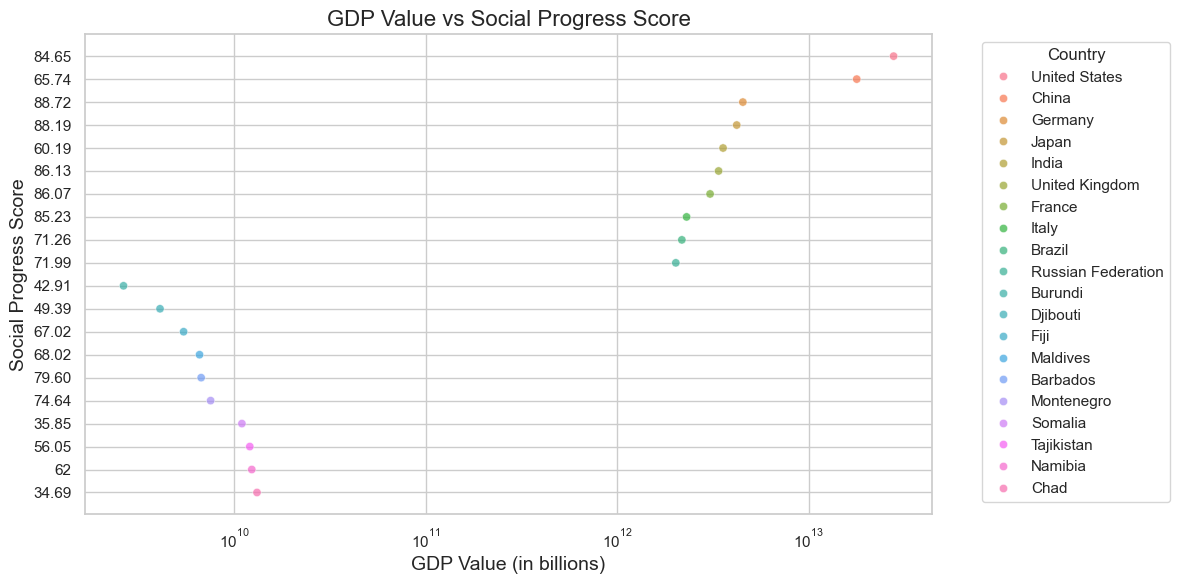

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filtered_gdp_df, x='gdp_value', y='social_progress_score', hue='country', alpha=0.7)

# Set the title and labels
plt.title('GDP Value vs Social Progress Score', fontsize=16)
plt.xlabel('GDP Value (in billions)', fontsize=14)
plt.ylabel('Social Progress Score', fontsize=14)
plt.xscale('log')  # Use log scale for better visibility
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

## Visualization #2 Scatter Plot

#### Datasets: Economic Indices(API)
#### Objective: Compare the Inflation Index with Gross Domestic Products(GDP) Index of countries
#### Filter: Considered 10 countries that have highest GDPs and 10 countries with lowest GDPs

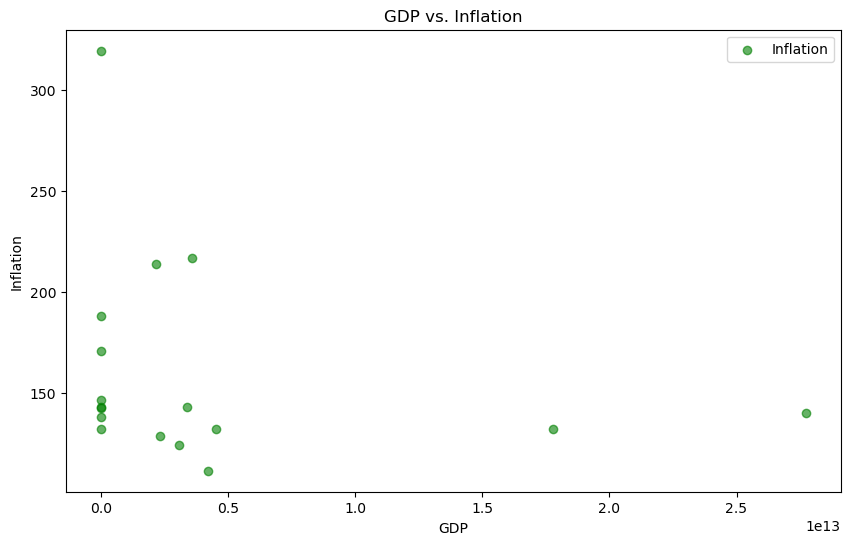

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot for GDP vs Inflation
plt.figure(figsize=(10, 6))
plt.scatter(filtered_gdp_df['gdp_value'], filtered_gdp_df['inflation_value'], label='Inflation', color='green', alpha=0.6)

# Add title and labels
plt.title('GDP vs. Inflation')
plt.xlabel('GDP')
plt.ylabel('Inflation')
plt.legend()
plt.show()

## Visualization #3 Line Plot

#### Datasets: Economic Indices(API) and Crime and Corruption Perception Indices(Flat File)
#### Objective: Study the correlation between Social Progress and Crime Index of countries

In [55]:
# Get the top 15 GDP Growth values
# filtered_gdp_growth_df = socia_economic_final_df.nlargest(15, 'gdp_growth_value')
filtered_gdp_growth_df = socia_economic_final_df.copy()

# Display the combined DataFrame
print(filtered_gdp_growth_df[['country', 'social_progress_score','Crime_Index_Score']])

         country social_progress_score  Crime_Index_Score
0    Afghanistan                 37.34               78.4
1        Albania                 74.12               45.4
2        Algeria                 65.59               51.4
3         Angola                 46.87               65.8
4      Argentina                 78.64               64.0
..           ...                   ...                ...
122      Uruguay                 80.27               51.9
123   Uzbekistan                 66.12               31.3
124     Viet Nam                 68.18               44.1
125       Zambia                 52.07               47.9
126     Zimbabwe                 52.17               60.6

[127 rows x 3 columns]


#### Creating the Line plot to compare Social Progress and Crime Index Score

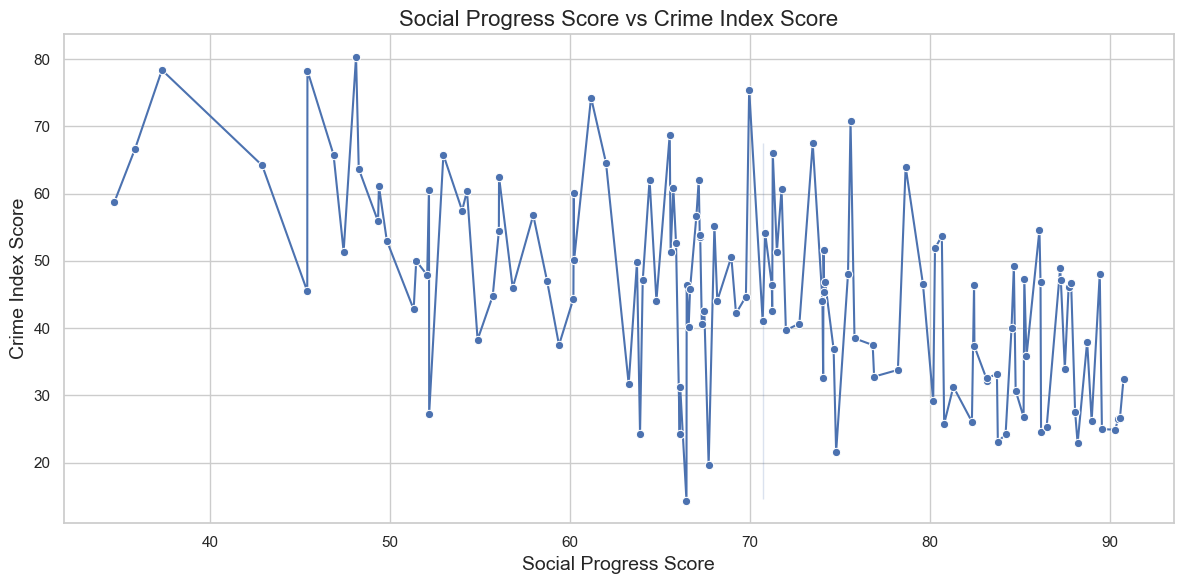

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert relevant columns to numeric types
filtered_gdp_growth_df['social_progress_score'] = pd.to_numeric(filtered_gdp_growth_df['social_progress_score'], errors='coerce')
filtered_gdp_growth_df['Crime_Index_Score'] = pd.to_numeric(filtered_gdp_growth_df['Crime_Index_Score'], errors='coerce')

# Drop rows with NaN values in the columns of interest
filtered_gdp_growth_df = filtered_gdp_growth_df.dropna(subset=['social_progress_score', 'Crime_Index_Score'])

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_gdp_growth_df, x='social_progress_score', y='Crime_Index_Score', marker='o')

# Set the title and labels
plt.title('Social Progress Score vs Crime Index Score', fontsize=16)
plt.xlabel('Social Progress Score', fontsize=14)
plt.ylabel('Crime Index Score', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

## Visualization 4 Column Bar Chart

#### Datasets: Economic Indices(API), Social Progress (Indices) and Crime and Corruption Perception Indices(Flat File)
#### Objective: Study the impact of Inflaion in Health & Wellness and Safety Index of countries
#### Filter: Considered 10 countries that have highest Inflation and 10 countries with lowest Inflations

<Figure size 4000x800 with 0 Axes>

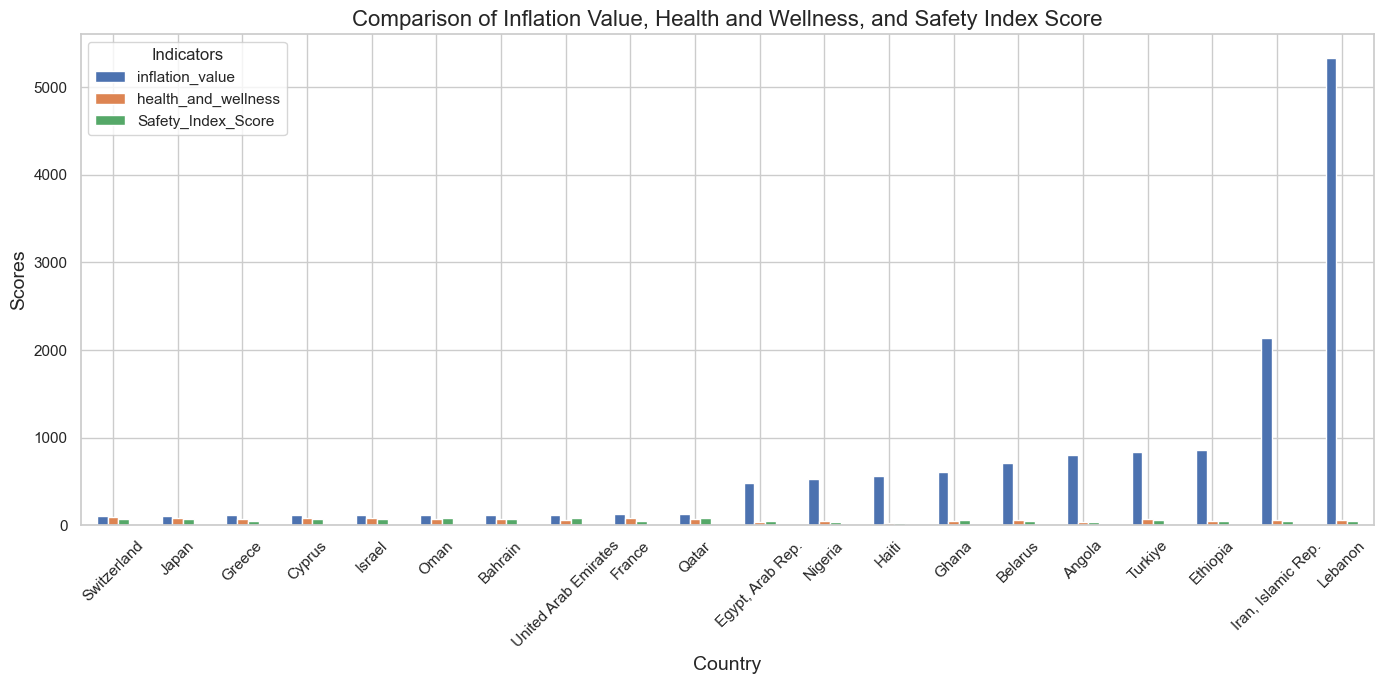

In [231]:
# Copy the DataFrame to a new variable
filtered_inflation_value_df = socia_economic_final_df.copy()

# Convert relevant columns to numeric types
filtered_inflation_value_df['inflation_value'] = pd.to_numeric(filtered_inflation_value_df['inflation_value'], errors='coerce')
filtered_inflation_value_df['health_and_wellness'] = pd.to_numeric(filtered_inflation_value_df['health_and_wellness'], errors='coerce')
filtered_inflation_value_df['Safety_Index_Score'] = pd.to_numeric(filtered_inflation_value_df['Safety_Index_Score'], errors='coerce')

# Drop rows with NaN values in the columns of interest
filtered_inflation_value_df = filtered_inflation_value_df.dropna(subset=['inflation_value', 'health_and_wellness', 'Safety_Index_Score'])

# Get the top 10 countries with the highest inflation values
top_10_inflation = filtered_inflation_value_df.nlargest(10, 'inflation_value')

# Get the bottom 10 countries with the lowest inflation values
bottom_10_inflation = filtered_inflation_value_df.nsmallest(10, 'inflation_value')

# Combine the top and bottom DataFrames
combined_inflation_df = pd.concat([top_10_inflation, bottom_10_inflation])

# Set the index to country names for better plotting
combined_inflation_df.set_index('country', inplace=True)

# Sort the combined DataFrame by inflation value for ordering the bars
combined_inflation_df.sort_values(by='inflation_value', ascending=True, inplace=True)

# Create a column chart
plt.figure(figsize=(40, 8))  # Updated size for better visibility
combined_inflation_df[['inflation_value', 'health_and_wellness', 'Safety_Index_Score']].plot(kind='bar', figsize=(14, 7))

# Set the title and labels
plt.title('Comparison of Inflation Value, Health and Wellness, and Safety Index Score', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Indicators')

# Show the plot
plt.tight_layout()
plt.show()

## Visualization #5 Bubble Chart

#### Datasets: Economic Indices(API), Social Progress (Indices) and Crime and Corruption Perception Indices(Flat File)
#### Objective: Study the role of Social Progress and Crime Index in GDP value of countries
#### Filter: Considered 10 countries that have highest and 10 countries with lowest GDP

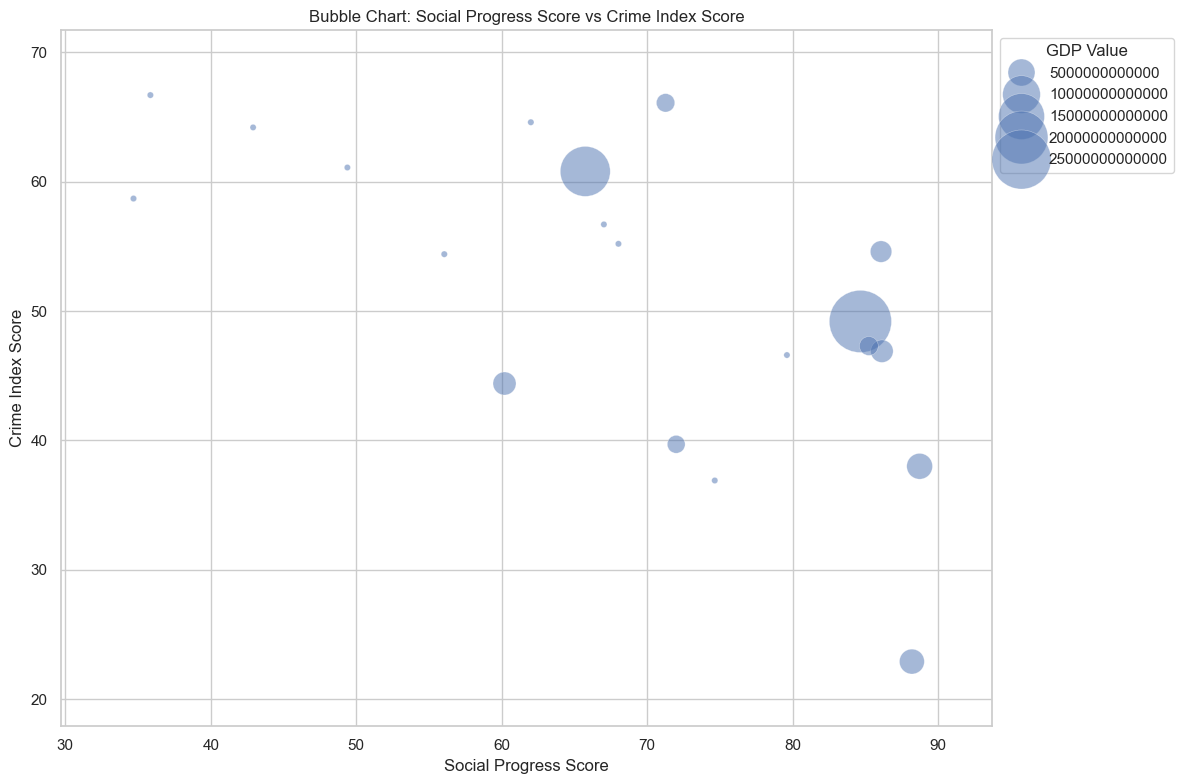

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('socia_economic_final_df_output.csv')

# Drop rows with NaN values in the required columns
compare_df = data.copy()
compare_df = compare_df.dropna(subset=['social_progress_score', 'Crime_Index_Score', 'gdp_value'])

# Get the top 10 and bottom 10 GDP values
top_10_gdp = compare_df.nlargest(10, 'gdp_value')
bottom_10_gdp = compare_df.nsmallest(10, 'gdp_value')

# Combine the results into a single DataFrame for visualization
filtered_compare_df = pd.concat([top_10_gdp, bottom_10_gdp])

# Create the bubble chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x='social_progress_score', 
                 y='Crime_Index_Score', 
                 size='gdp_value', 
                 sizes=(20, 2000), 
                 alpha=0.5, 
                 data=filtered_compare_df)

# Set limits for axes based on sorted values
plt.xlim(filtered_compare_df['social_progress_score'].min() - 5, 
         filtered_compare_df['social_progress_score'].max() + 5)
plt.ylim(filtered_compare_df['Crime_Index_Score'].min() - 5, 
         filtered_compare_df['Crime_Index_Score'].max() + 5)

# Add the title and labels
plt.title('Bubble Chart: Social Progress Score vs Crime Index Score')
plt.xlabel('Social Progress Score')
plt.ylabel('Crime Index Score')

# Show the legend outside of the chart
plt.legend(title='GDP Value', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

# Task 3: Final Dataset

In [76]:
# Printing the final dataset

socia_economic_final_df.head(5)

,country_iso_code,country,gdp_value,gdp_growth_value,inflation_value,gs_export_value,social_progress_score,basic_human_needs,foundations_of_wellbeing,nutrition_and_basic_medical_care,...,personal_freedom_and_choice,inclusiveness,access_to_advanced_education,Crime_Index_Score,Global_Organized_Crime_Score,Criminal_Markets_Score,Criminal_Actors_Score,Resilience_Score,Safety_Index_Score,Corruption_Perception_Score
0,AFG,Afghanistan,1.723305e+10,2.710887,NaN,-9.027678,37.34,53.69,32.60,60.78,...,30.81,18.13,27.85,78.4,7.10,7.00,7.2,1.50,21.6,20.0
1,ALB,Albania,2.354718e+10,3.936625,138.021864,9.453514,74.12,84.56,76.43,92.15,...,52.59,53.29,56.74,45.4,5.17,4.83,5.5,5.13,54.6,37.0
2,DZA,Algeria,2.476262e+11,4.100000,198.550858,3.400000,65.59,80.37,62.40,89.93,...,65.28,47.07,50.24,51.4,4.88,5.17,4.6,4.38,48.6,36.0
3,AGO,Angola,8.482465e+10,1.001289,804.965533,-6.184776,46.87,54.18,47.02,67.83,...,50.78,25.71,24.96,65.8,5.58,5.17,6.0,4.50,34.2,33.0
4,ARG,Argentina,6.460753e+11,-1.611002,NaN,-7.512632,78.64,82.28,76.93,91.64,...,66,75.54,75.34,64.0,5.00,4.50,5.5,5.96,36.0,37.0


# Ethical Implications

**1. What changes were made to the data?**

- Validated and handled duplicate records
- Validated and handled NaN values in essential columns
- Validated and corrected for data type inconsistencies
- Validated and corrected (added and renamed) column names
- Identified and thoroughly examined the outliers in the datasets
- **Milestone 5** Validated and corrected the Country Name in the dataset(Flat File) and (Web Scrapping) to be compliant with Country Name in ISO format

**2. Are there any legal or regulatory guidelines for your data or project topic?**
- **Crime and Corruption Perception Dataset (Flat File):** As per the source, https://worldpopulationreview.com and https://www.numbeo.com, Terms of Use allow to freely use their data for personal, academic, and journalistic purposes. There are no restriction since the data is NOT used for Commercial Purpose
- **Social Progress Dataset (Web Scrapping):** Wikipedia content is generally licensed under the Creative Commons Attribution-ShareAlike 4.0 International License which allows users to use and share the material provided credit for the original source is given. 
- **Econimic Dataset (API):** The World Bank fosters transparency and accessibility via its Open Data initiative, enabling public access to a diverse array of datasets. Most of its data is provided under the Creative Commons Attribution 4.0 International License, allowing for sharing and adaptation with proper attribution. 

**3. What risks could be created based on the transformations done?**
- **Crime and Corruption Perception Dataset (Flat File):** There are two risks associated with the transformations applied to the dataset. First, we removed countries with NaN values in key columns of the Crime Rate dataset, which restricts our ability to analyze social well-being and economic indices by comparing them to the crime index of these countries. Second, our approach to handling missing data—by filling in missing values with mean values for the time series—could reduce the accuracy of the analysis for certain countries.
- **Social Progress Dataset (Web Scrapping):** There are no explicit risk evident by the transformation. There are no countries with NaN values for any of the social progress parameters and there are no missing data
- **Econimic Dataset (API):** There are no risks introduced by data transformation activities performed since activities performed in the dataset are related to filtering out unreleated, duplicate data and ruling out the outlier information as natural variations
- **Milestone 5:** To make the some of the visuals uncluttered, I have limited the dataset to particualr countries (For example: 10 countries with lowest GDPs, 10 countries with highest Inflation, etc.,), it is important to know the visuals are a part of subset of data and not overall data.

**4. Did you make any assumptions in cleaning/transforming the data?**
- There are **no assumption** made during cleaning/transformation

**5. How was your data sourced / verified for credibility?**

- **Crime and Corruption Perception Dataset (Flat File):** Datasets in World Popuation Review Web Portal was requested and received via email from the administrator of the Web Portal
- **Social Progress Dataset (Web Scrapping):** The Social Progress Imperative consulted researchers, including those from the Massachusetts Institute of Technology (MIT), to identify the most effective indicators for distinguishing national performance. I have researched for the outlier values to validate the social progress indexes such as water, sanitation, environemntal parameters and found the data to be credible and in line with real-world.
- **Econimic Dataset (API):** The World Bank which is considered as one of the most trusted, credible sources. As a part of this milestone, I have researched the economic index values for countries with outlier values in GDP, GDP Growth, Inflation, and Goods & Services Exports. Australia’s high GDP stems from rich natural resources like iron ore, coal, and gas. Guyana's GDP per capita is rising rapidly due to oil production. Conversely, Sudan's low exports are due to lost oil revenues after South Sudan's secession, political instability, and limited infrastructure.

**6. Was your data acquired in an ethical way?**

- **Crime and Corruption Perception Dataset (Flat File):** World Population Review Portal list Numbeo Portal as one of their source of information. After reviewing the privay Policy of Numbeo portal, it is safe to assume that the data was aqcuired in ethical way based on their process based approach to collect data.
- **Social Progress Dataset (Web Scrapping):** Guiding principles used in the source web portal indicates a fair assessment was done with the objective focusing on outcomes that matters to lives of people. It is safe to assume that data is gathered from diverse sources to cover various sections of global society
- **Econimic Dataset (API):** The World Bank is committed to acquiring data ethically and takes maximum efforts to maintain ethical standards in data acquisition

**7. How would you mitigate any of the ethical implications you have identified?**

- **Crime and Corruption Perception Dataset (Flat File):** While there are no ethical implication that I see on this project, it is critical to highlight that NOT all the countries maintain similar methods to report, document, and organize Crime Data and the report of an actual crime is significantly different for each country.
- **Social Progress Dataset (Web Scrapping):** While there are no ethical implication that I see on this project, it is critical to highlight that different cultures interpret progress through various lenses, often prioritizing specific indices that reflect their unique values and societal norms.
- **Econimic Dataset (API):** While there are no ethical implication that I see on this project, it is critical to ensure that instead of perpetuating global inequalities, analyses should highlight and address disparities. Involving local researchers and stakeholders can improve ethical standards and ensure culturally relevant interpretations.